In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Knowledge Distillation Tutorial
===============================

**Author**: [Alexandros Chariton](https://github.com/AlexandrosChrtn)


Knowledge distillation is a technique that enables knowledge transfer
from large, computationally expensive models to smaller ones without
losing validity. This allows for deployment on less powerful hardware,
making evaluation faster and more efficient.

In this tutorial, we will run a number of experiments focused at
improving the accuracy of a lightweight neural network, using a more
powerful network as a teacher. The computational cost and the speed of
the lightweight network will remain unaffected, our intervention only
focuses on its weights, not on its forward pass. Applications of this
technology can be found in devices such as drones or mobile phones. In
this tutorial, we do not use any external packages as everything we need
is available in `torch` and `torchvision`.

In this tutorial, you will learn:

-   How to modify model classes to extract hidden representations and
    use them for further calculations
-   How to modify regular train loops in PyTorch to include additional
    losses on top of, for example, cross-entropy for classification
-   How to improve the performance of lightweight models by using more
    complex models as teachers

Prerequisites
=============

-   1 GPU, 4GB of memory
-   PyTorch v2.0 or later
-   CIFAR-10 dataset (downloaded by the script and saved in a directory
    called `/data`)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading CIFAR-10
================

CIFAR-10 is a popular image dataset with ten classes. Our objective is
to predict one of the following classes for each input image.

![Example of CIFAR-10
images](https://pytorch.org/tutorials//../_static/img/cifar10.png){.align-center}

The input images are RGB, so they have 3 channels and are 32x32 pixels.
Basically, each image is described by 3 x 32 x 32 = 3072 numbers ranging
from 0 to 255. A common practice in neural networks is to normalize the
input, which is done for multiple reasons, including avoiding saturation
in commonly used activation functions and increasing numerical
stability. Our normalization process consists of subtracting the mean
and dividing by the standard deviation along each channel. The tensors
\"mean=\[0.485, 0.456, 0.406\]\" and \"std=\[0.229, 0.224, 0.225\]\"
were already computed, and they represent the mean and standard
deviation of each channel in the predefined subset of CIFAR-10 intended
to be the training set. Notice how we use these values for the test set
as well, without recomputing the mean and standard deviation from
scratch. This is because the network was trained on features produced by
subtracting and dividing the numbers above, and we want to maintain
consistency. Furthermore, in real life, we would not be able to compute
the mean and standard deviation of the test set since, under our
assumptions, this data would not be accessible at that point.

As a closing point, we often refer to this held-out set as the
validation set, and we use a separate set, called the test set, after
optimizing a model\'s performance on the validation set. This is done to
avoid selecting a model based on the greedy and biased optimization of a
single metric.


In [3]:
# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

Files already downloaded and verified
Files already downloaded and verified


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>This section is for CPU users only who are interested in quick results. Use this option only if you're interested in a small scale experiment. Keep in mind the code should run fairly quickly using any GPU. Select only the first <code>num_images_to_keep</code> images from the train/test dataset<pre><code>#from torch.utils.data import Subset</p>
<h1>num_images_to_keep = 2000</h1>
<h1>train_dataset = Subset(train_dataset, range(min(num_images_to_keep, 50_000)))</h1>
<h1>test_dataset = Subset(test_dataset, range(min(num_images_to_keep, 10_000)))</code></pre></h1>
</div>


In [4]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Defining model classes and utility functions
============================================

Next, we need to define our model classes. Several user-defined
parameters need to be set here. We use two different architectures,
keeping the number of filters fixed across our experiments to ensure
fair comparisons. Both architectures are Convolutional Neural Networks
(CNNs) with a different number of convolutional layers that serve as
feature extractors, followed by a classifier with 10 classes. The number
of filters and neurons is smaller for the students.


In [5]:
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

We employ 2 functions to help us produce and evaluate the results on our
original classification task. One function is called `train` and takes
the following arguments:

-   `model`: A model instance to train (update its weights) via this
    function.
-   `train_loader`: We defined our `train_loader` above, and its job is
    to feed the data into the model.
-   `epochs`: How many times we loop over the dataset.
-   `learning_rate`: The learning rate determines how large our steps
    towards convergence should be. Too large or too small steps can be
    detrimental.
-   `device`: Determines the device to run the workload on. Can be
    either CPU or GPU depending on availability.

Our test function is similar, but it will be invoked with `test_loader`
to load images from the test set.

![Train both networks with Cross-Entropy. The student will be used as a
baseline:](https://pytorch.org/tutorials//../_static/img/knowledge_distillation/ce_only.png){.align-center}


In [6]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

Cross-entropy runs
==================

For reproducibility, we need to set the torch manual seed. We train
networks using different methods, so to compare them fairly, it makes
sense to initialize the networks with the same weights. Start by
training the teacher network using cross-entropy:


In [7]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)
train(nn_deep, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, test_loader, device)

# Instantiate the lightweight network:
torch.manual_seed(42)
nn_light = LightNN(num_classes=10).to(device)

Epoch 1/10, Loss: 1.3360217712114535
Epoch 2/10, Loss: 0.8668371425260364
Epoch 3/10, Loss: 0.6788111447220873
Epoch 4/10, Loss: 0.5356179978079199
Epoch 5/10, Loss: 0.417079504264895
Epoch 6/10, Loss: 0.3095289291551961
Epoch 7/10, Loss: 0.22194518051717593
Epoch 8/10, Loss: 0.17308205389000875
Epoch 9/10, Loss: 0.14370786798808277
Epoch 10/10, Loss: 0.12091531485433468
Test Accuracy: 74.97%


We instantiate one more lightweight network model to compare their
performances. Back propagation is sensitive to weight initialization, so
we need to make sure these two networks have the exact same
initialization.


In [8]:
torch.manual_seed(42)
new_nn_light = LightNN(num_classes=10).to(device)

To ensure we have created a copy of the first network, we inspect the
norm of its first layer. If it matches, then we are safe to conclude
that the networks are indeed the same.


In [9]:
# Print the norm of the first layer of the initial lightweight model
print("Norm of 1st layer of nn_light:", torch.norm(nn_light.features[0].weight).item())
# Print the norm of the first layer of the new lightweight model
print("Norm of 1st layer of new_nn_light:", torch.norm(new_nn_light.features[0].weight).item())

Norm of 1st layer of nn_light: 2.327361822128296
Norm of 1st layer of new_nn_light: 2.327361822128296


Print the total number of parameters in each model:


In [10]:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNN parameters: {total_params_light}")

DeepNN parameters: 1,186,986
LightNN parameters: 267,738


Train and test the lightweight network with cross entropy loss:


In [11]:
train(nn_light, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_light_ce = test(nn_light, test_loader, device)

Epoch 1/10, Loss: 1.4703212781330508
Epoch 2/10, Loss: 1.156116452668329
Epoch 3/10, Loss: 1.0196734470174746
Epoch 4/10, Loss: 0.9170225928811466
Epoch 5/10, Loss: 0.840861413789832
Epoch 6/10, Loss: 0.7760914690659174
Epoch 7/10, Loss: 0.7088508092991227
Epoch 8/10, Loss: 0.6539685826777192
Epoch 9/10, Loss: 0.6033840322738413
Epoch 10/10, Loss: 0.5544070611372018
Test Accuracy: 70.47%


As we can see, based on test accuracy, we can now compare the deeper
network that is to be used as a teacher with the lightweight network
that is our supposed student. So far, our student has not intervened
with the teacher, therefore this performance is achieved by the student
itself. The metrics so far can be seen with the following lines:


In [12]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy: {test_accuracy_light_ce:.2f}%")

Teacher accuracy: 74.97%
Student accuracy: 70.47%


Knowledge distillation run
==========================

Now let\'s try to improve the test accuracy of the student network by
incorporating the teacher. Knowledge distillation is a straightforward
technique to achieve this, based on the fact that both networks output a
probability distribution over our classes. Therefore, the two networks
share the same number of output neurons. The method works by
incorporating an additional loss into the traditional cross entropy
loss, which is based on the softmax output of the teacher network. The
assumption is that the output activations of a properly trained teacher
network carry additional information that can be leveraged by a student
network during training. The original work suggests that utilizing
ratios of smaller probabilities in the soft targets can help achieve the
underlying objective of deep neural networks, which is to create a
similarity structure over the data where similar objects are mapped
closer together. For example, in CIFAR-10, a truck could be mistaken for
an automobile or airplane, if its wheels are present, but it is less
likely to be mistaken for a dog. Therefore, it makes sense to assume
that valuable information resides not only in the top prediction of a
properly trained model but in the entire output distribution. However,
cross entropy alone does not sufficiently exploit this information as
the activations for non-predicted classes tend to be so small that
propagated gradients do not meaningfully change the weights to construct
this desirable vector space.

As we continue defining our first helper function that introduces a
teacher-student dynamic, we need to include a few extra parameters:

-   `T`: Temperature controls the smoothness of the output
    distributions. Larger `T` leads to smoother distributions, thus
    smaller probabilities get a larger boost.
-   `soft_target_loss_weight`: A weight assigned to the extra objective
    we\'re about to include.
-   `ce_loss_weight`: A weight assigned to cross-entropy. Tuning these
    weights pushes the network towards optimizing for either objective.

![Distillation loss is calculated from the logits of the networks. It
only returns gradients to the
student:](https://pytorch.org/tutorials//../_static/img/knowledge_distillation/distillation_output_loss.png){.align-center}


In [13]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(
    teacher=nn_deep, 
    student=new_nn_light,
    train_loader=train_loader, 
    epochs=10, learning_rate=0.001, 
    T=5, 
    soft_target_loss_weight=0.25, 
    ce_loss_weight=0.75, 
    device=device)
test_accuracy_light_ce_and_kd = test(new_nn_light, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Epoch 1/10, Loss: 6.0185535484567625
Epoch 2/10, Loss: 4.53818423302887
Epoch 3/10, Loss: 3.904600916006376
Epoch 4/10, Loss: 3.460118593767171
Epoch 5/10, Loss: 3.1411117342731836
Epoch 6/10, Loss: 2.8552747791075643
Epoch 7/10, Loss: 2.638725581681332
Epoch 8/10, Loss: 2.4375663178656106
Epoch 9/10, Loss: 2.286572817646329
Epoch 10/10, Loss: 2.1310494263153856
Test Accuracy: 70.76%
Teacher accuracy: 74.97%
Student accuracy without teacher: 70.47%
Student accuracy with CE + KD: 70.76%


Cosine loss minimization run
============================

Feel free to play around with the temperature parameter that controls
the softness of the softmax function and the loss coefficients. In
neural networks, it is easy to include additional loss functions to the
main objectives to achieve goals like better generalization. Let\'s try
including an objective for the student, but now let\'s focus on their
hidden states rather than their output layers. Our goal is to convey
information from the teacher\'s representation to the student by
including a naive loss function, whose minimization implies that the
flattened vectors that are subsequently passed to the classifiers have
become more *similar* as the loss decreases. Of course, the teacher does
not update its weights, so the minimization depends only on the
student\'s weights. The rationale behind this method is that we are
operating under the assumption that the teacher model has a better
internal representation that is unlikely to be achieved by the student
without external intervention, therefore we artificially push the
student to mimic the internal representation of the teacher. Whether or
not this will end up helping the student is not straightforward, though,
because pushing the lightweight network to reach this point could be a
good thing, assuming that we have found an internal representation that
leads to better test accuracy, but it could also be harmful because the
networks have different architectures and the student does not have the
same learning capacity as the teacher. In other words, there is no
reason for these two vectors, the student\'s and the teacher\'s to match
per component. The student could reach an internal representation that
is a permutation of the teacher\'s and it would be just as efficient.
Nonetheless, we can still run a quick experiment to figure out the
impact of this method. We will be using the `CosineEmbeddingLoss` which
is given by the following formula:

![Formula for
CosineEmbeddingLoss](https://pytorch.org/tutorials//../_static/img/knowledge_distillation/cosine_embedding_loss.png){.align-center
width="450px"}

Obviously, there is one thing that we need to resolve first. When we
applied distillation to the output layer we mentioned that both networks
have the same number of neurons, equal to the number of classes.
However, this is not the case for the layer following our convolutional
layers. Here, the teacher has more neurons than the student after the
flattening of the final convolutional layer. Our loss function accepts
two vectors of equal dimensionality as inputs, therefore we need to
somehow match them. We will solve this by including an average pooling
layer after the teacher\'s convolutional layer to reduce its
dimensionality to match that of the student.

To proceed, we will modify our model classes, or create new ones. Now,
the forward function returns not only the logits of the network but also
the flattened hidden representation after the convolutional layer. We
include the aforementioned pooling for the modified teacher.


In [14]:
class ModifiedDeepNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        flattened_conv_output_after_pooling = torch.nn.functional.avg_pool1d(flattened_conv_output, 2)
        return x, flattened_conv_output_after_pooling

# Create a similar student class where we return a tuple. We do not apply pooling after flattening.
class ModifiedLightNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        return x, flattened_conv_output

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep = ModifiedDeepNNCosine(num_classes=10).to(device)
modified_nn_deep.load_state_dict(nn_deep.state_dict())

# Once again ensure the norm of the first layer is the same for both networks
print("Norm of 1st layer for deep_nn:", torch.norm(nn_deep.features[0].weight).item())
print("Norm of 1st layer for modified_deep_nn:", torch.norm(modified_nn_deep.features[0].weight).item())

# Initialize a modified lightweight network with the same seed as our other lightweight instances. This will be trained from scratch to examine the effectiveness of cosine loss minimization.
torch.manual_seed(42)
modified_nn_light = ModifiedLightNNCosine(num_classes=10).to(device)
print("Norm of 1st layer:", torch.norm(modified_nn_light.features[0].weight).item())

Norm of 1st layer for deep_nn: 7.4731903076171875
Norm of 1st layer for modified_deep_nn: 7.4731903076171875
Norm of 1st layer: 2.327361822128296


Naturally, we need to change the train loop because now the model
returns a tuple `(logits, hidden_representation)`. Using a sample input
tensor we can print their shapes.


In [15]:
# Create a sample input tensor
sample_input = torch.randn(128, 3, 32, 32).to(device) # Batch size: 128, Filters: 3, Image size: 32x32

# Pass the input through the student
logits, hidden_representation = modified_nn_light(sample_input)

# Print the shapes of the tensors
print("Student logits shape:", logits.shape) # batch_size x total_classes
print("Student hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

# Pass the input through the teacher
logits, hidden_representation = modified_nn_deep(sample_input)

# Print the shapes of the tensors
print("Teacher logits shape:", logits.shape) # batch_size x total_classes
print("Teacher hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

Student logits shape: torch.Size([128, 10])
Student hidden representation shape: torch.Size([128, 1024])
Teacher logits shape: torch.Size([128, 10])
Teacher hidden representation shape: torch.Size([128, 1024])


In our case, `hidden_representation_size` is `1024`. This is the
flattened feature map of the final convolutional layer of the student
and as you can see, it is the input for its classifier. It is `1024` for
the teacher too, because we made it so with `avg_pool1d` from `2048`.
The loss applied here only affects the weights of the student prior to
the loss calculation. In other words, it does not affect the classifier
of the student. The modified training loop is the following:

![In Cosine Loss minimization, we want to maximize the cosine similarity
of the two representations by returning gradients to the
student:](https://pytorch.org/tutorials//../_static/img/knowledge_distillation/cosine_loss_distillation.png){.align-center}


In [16]:
def train_cosine_loss(teacher, student, train_loader, epochs, learning_rate, hidden_rep_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    cosine_loss = nn.CosineEmbeddingLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model and keep only the hidden representation
            with torch.no_grad():
                _, teacher_hidden_representation = teacher(inputs)

            # Forward pass with the student model
            student_logits, student_hidden_representation = student(inputs)

            # Calculate the cosine loss. Target is a vector of ones. From the loss formula above we can see that is the case where loss minimization leads to cosine similarity increase.
            hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(inputs.size(0)).to(device))

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

We need to modify our test function for the same reason. Here we ignore
the hidden representation returned by the model.


In [17]:
def test_multiple_outputs(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs) # Disregard the second tensor of the tuple
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In this case, we could easily include both knowledge distillation and
cosine loss minimization in the same function. It is common to combine
methods to achieve better performance in teacher-student paradigms. For
now, we can run a simple train-test session.


In [18]:
# Train and test the lightweight network with cross entropy loss
train_cosine_loss(teacher=modified_nn_deep, student=modified_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, hidden_rep_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_cosine_loss = test_multiple_outputs(modified_nn_light, test_loader, device)

Epoch 1/10, Loss: 1.3027256727218628
Epoch 2/10, Loss: 1.0714961465667276
Epoch 3/10, Loss: 0.9731437036448427
Epoch 4/10, Loss: 0.8975080013884913
Epoch 5/10, Loss: 0.8426412779961705
Epoch 6/10, Loss: 0.7971104705120291
Epoch 7/10, Loss: 0.7572639119594603
Epoch 8/10, Loss: 0.719452841964829
Epoch 9/10, Loss: 0.6825829622385752
Epoch 10/10, Loss: 0.658657803254969
Test Accuracy: 70.45%


Intermediate regressor run
==========================

Our naive minimization does not guarantee better results for several
reasons, one being the dimensionality of the vectors. Cosine similarity
generally works better than Euclidean distance for vectors of higher
dimensionality, but we were dealing with vectors with 1024 components
each, so it is much harder to extract meaningful similarities.
Furthermore, as we mentioned, pushing towards a match of the hidden
representation of the teacher and the student is not supported by
theory. There are no good reasons why we should be aiming for a 1:1
match of these vectors. We will provide a final example of training
intervention by including an extra network called regressor. The
objective is to first extract the feature map of the teacher after a
convolutional layer, then extract a feature map of the student after a
convolutional layer, and finally try to match these maps. However, this
time, we will introduce a regressor between the networks to facilitate
the matching process. The regressor will be trainable and ideally will
do a better job than our naive cosine loss minimization scheme. Its main
job is to match the dimensionality of these feature maps so that we can
properly define a loss function between the teacher and the student.
Defining such a loss function provides a teaching \"path,\" which is
basically a flow to back-propagate gradients that will change the
student\'s weights. Focusing on the output of the convolutional layers
right before each classifier for our original networks, we have the
following shapes:


In [19]:
# Pass the sample input only from the convolutional feature extractor
convolutional_fe_output_student = nn_light.features(sample_input)
convolutional_fe_output_teacher = nn_deep.features(sample_input)

# Print their shapes
print("Student's feature extractor output shape: ", convolutional_fe_output_student.shape)
print("Teacher's feature extractor output shape: ", convolutional_fe_output_teacher.shape)

Student's feature extractor output shape:  torch.Size([128, 16, 8, 8])
Teacher's feature extractor output shape:  torch.Size([128, 32, 8, 8])


We have 32 filters for the teacher and 16 filters for the student. We
will include a trainable layer that converts the feature map of the
student to the shape of the feature map of the teacher. In practice, we
modify the lightweight class to return the hidden state after an
intermediate regressor that matches the sizes of the convolutional
feature maps and the teacher class to return the output of the final
convolutional layer without pooling or flattening.

![The trainable layer matches the shapes of the intermediate tensors and
Mean Squared Error (MSE) is properly
defined:](https://pytorch.org/tutorials//../_static/img/knowledge_distillation/fitnets_knowledge_distill.png){.align-center}


In [20]:
class ModifiedDeepNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        conv_feature_map = x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map

class ModifiedLightNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Include an extra regressor (in our case linear)
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        regressor_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output

After that, we have to update our train loop again. This time, we
extract the regressor output of the student, the feature map of the
teacher, we calculate the `MSE` on these tensors (they have the exact
same shape so it\'s properly defined) and we back propagate gradients
based on that loss, in addition to the regular cross entropy loss of the
classification task.


In [21]:
def train_mse_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Again ignore teacher logits
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)

            # Forward pass with the student model
            student_logits, regressor_feature_map = student(inputs)

            # Calculate the loss
            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Notice how our test function remains the same here with the one we used in our previous case. We only care about the actual outputs because we measure accuracy.

# Initialize a ModifiedLightNNRegressor
torch.manual_seed(42)
modified_nn_light_reg = ModifiedLightNNRegressor(num_classes=10).to(device)

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep_reg = ModifiedDeepNNRegressor(num_classes=10).to(device)
modified_nn_deep_reg.load_state_dict(nn_deep.state_dict())

# Train and test once again
train_mse_loss(teacher=modified_nn_deep_reg, student=modified_nn_light_reg, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_mse_loss = test_multiple_outputs(modified_nn_light_reg, test_loader, device)

Epoch 1/10, Loss: 1.7518541151300415
Epoch 2/10, Loss: 1.3610749906286255
Epoch 3/10, Loss: 1.2103135954693456
Epoch 4/10, Loss: 1.1101424372409616
Epoch 5/10, Loss: 1.0289272960189664
Epoch 6/10, Loss: 0.9639695692245308
Epoch 7/10, Loss: 0.908274811856887
Epoch 8/10, Loss: 0.8563194689543351
Epoch 9/10, Loss: 0.8146207352428485
Epoch 10/10, Loss: 0.7754909931241399
Test Accuracy: 71.52%


It is expected that the final method will work better than `CosineLoss`
because now we have allowed a trainable layer between the teacher and
the student, which gives the student some wiggle room when it comes to
learning, rather than pushing the student to copy the teacher\'s
representation. Including the extra network is the idea behind
hint-based distillation.


In [22]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")
print(f"Student accuracy with CE + CosineLoss: {test_accuracy_light_ce_and_cosine_loss:.2f}%")
print(f"Student accuracy with CE + RegressorMSE: {test_accuracy_light_ce_and_mse_loss:.2f}%")

Teacher accuracy: 74.97%
Student accuracy without teacher: 70.47%
Student accuracy with CE + KD: 70.76%
Student accuracy with CE + CosineLoss: 70.45%
Student accuracy with CE + RegressorMSE: 71.52%


Conclusion
==========

None of the methods above increases the number of parameters for the
network or inference time, so the performance increase comes at the
little cost of calculating gradients during training. In ML
applications, we mostly care about inference time because training
happens before the model deployment. If our lightweight model is still
too heavy for deployment, we can apply different ideas, such as
post-training quantization. Additional losses can be applied in many
tasks, not just classification, and you can experiment with quantities
like coefficients, temperature, or number of neurons. Feel free to tune
any numbers in the tutorial above, but keep in mind, if you change the
number of neurons / filters chances are a shape mismatch might occur.

For more information, see:

-   [Hinton, G., Vinyals, O., Dean, J.: Distilling the knowledge in a
    neural network. In: Neural Information Processing System Deep
    Learning Workshop (2015)](https://arxiv.org/abs/1503.02531)
-   [Romero, A., Ballas, N., Kahou, S.E., Chassang, A., Gatta, C.,
    Bengio, Y.: Fitnets: Hints for thin deep nets. In: Proceedings of
    the International Conference on Learning
    Representations (2015)](https://arxiv.org/abs/1412.6550)


## Checking on different weight initialization

In [23]:
# 1. Xavier (Glorot) Initialization
def init_weights_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# 2. Kaiming (He) Initialization
def init_weights_kaiming(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# 3. Orthogonal Initialization
def init_weights_orthogonal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# 4. Initialization from teacher weights (for matching layers)
def init_from_teacher(student, teacher):
    student_state_dict = student.state_dict()
    teacher_state_dict = teacher.state_dict()
    
    for student_param, teacher_param in zip(student_state_dict, teacher_state_dict):
        if student_state_dict[student_param].shape == teacher_state_dict[teacher_param].shape:
            student_state_dict[student_param] = teacher_state_dict[teacher_param]
    init_weights_xavier
    student.load_state_dict(student_state_dict)

In [24]:
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10, init_method='default'):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

        if init_method == 'xavier':
            self.apply(init_weights_xavier)
        elif init_method == 'kaiming':
            self.apply(init_weights_kaiming)
        elif init_method == 'orthogonal':
            self.apply(init_weights_orthogonal)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [25]:
def compare_initializations(teacher, train_loader, test_loader, device, epochs=10, learning_rate=0.001):
    initialization_methods = ['default', 'xavier', 'kaiming', 'orthogonal', 'teacher']
    results = {}

    for method in initialization_methods:
        print(f"\nTraining with {method} initialization:")
        if method == 'teacher':
            student = LightNN(num_classes=10).to(device)
            init_from_teacher(student, teacher)
        else:
            student = LightNN(num_classes=10, init_method=method).to(device)
        
        # Train the student using knowledge distillation
        train_knowledge_distillation(
            teacher=teacher,
            student=student,
            train_loader=train_loader,
            epochs=epochs,
            learning_rate=learning_rate,
            T=5,  # You can experiment with different temperature values
            soft_target_loss_weight=0.5,
            ce_loss_weight=0.5,
            device=device
        )
        
        # Test the student
        accuracy = test(student, test_loader, device)
        results[method] = accuracy

    return results

# Usage
teacher = DeepNN(num_classes=10).to(device)
# Assume the teacher is already trained

results = compare_initializations(teacher, train_loader, test_loader, device)

# Print results
for method, accuracy in results.items():
    print(f"{method.capitalize()} initialization accuracy: {accuracy:.2f}%")


Training with default initialization:
Epoch 1/10, Loss: 0.9353510574306674
Epoch 2/10, Loss: 0.8382541858936514
Epoch 3/10, Loss: 0.7995569042842406
Epoch 4/10, Loss: 0.776187486965638
Epoch 5/10, Loss: 0.7579809369333564
Epoch 6/10, Loss: 0.7426976093550777
Epoch 7/10, Loss: 0.7301900601752883
Epoch 8/10, Loss: 0.7182012898537814
Epoch 9/10, Loss: 0.7079676193044618
Epoch 10/10, Loss: 0.6985625444775652
Test Accuracy: 70.36%

Training with xavier initialization:
Epoch 1/10, Loss: 0.93826978865182
Epoch 2/10, Loss: 0.8369867958681053
Epoch 3/10, Loss: 0.7958332789523522
Epoch 4/10, Loss: 0.7686307133006318
Epoch 5/10, Loss: 0.7482400599038205
Epoch 6/10, Loss: 0.731926961475626
Epoch 7/10, Loss: 0.7154550468525314
Epoch 8/10, Loss: 0.7021473326036692
Epoch 9/10, Loss: 0.6882188027472143
Epoch 10/10, Loss: 0.6765888244904521
Test Accuracy: 70.39%

Training with kaiming initialization:
Epoch 1/10, Loss: 1.3985702537209785
Epoch 2/10, Loss: 1.013998351743459
Epoch 3/10, Loss: 0.963482200

In [26]:
from torch.nn import functional as F

In [27]:
class ModifiedDeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.features(x)
        flattened = torch.flatten(features, 1)
        output = self.classifier(flattened)
        return output, flattened, features

class ModifiedLightNN(nn.Module):
    def __init__(self, num_classes=10, init_method='default'):
        super(ModifiedLightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        self.adapter = nn.Linear(1024, 2048)  # Add this line to match teacher's feature dimension
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
        
        if init_method == 'xavier':
            self.apply(init_weights_xavier)
        elif init_method == 'kaiming':
            self.apply(init_weights_kaiming)
        elif init_method == 'orthogonal':
            self.apply(init_weights_orthogonal)
        # 'default' uses PyTorch's default initialization

    def forward(self, x):
        features = self.features(x)
        regressor_output = self.regressor(features)
        flattened = torch.flatten(features, 1)
        adapted_features = self.adapter(flattened)  # Adapt features to match teacher's dimension
        output = self.classifier(flattened)
        return output, adapted_features, regressor_output

In [28]:
def train_cosine_loss(teacher, student, train_loader, epochs, learning_rate, cosine_loss_weight, ce_loss_weight, device):
    criterion_ce = nn.CrossEntropyLoss()
    criterion_cosine = nn.CosineEmbeddingLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                _, teacher_features, _ = teacher(inputs)

            student_outputs, student_features, _ = student(inputs)

            loss_ce = criterion_ce(student_outputs, labels)
            loss_cosine = criterion_cosine(student_features, teacher_features, torch.ones(inputs.size(0)).to(device))

            loss = ce_loss_weight * loss_ce + cosine_loss_weight * loss_cosine
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [29]:
def train_kd(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    criterion_ce = nn.CrossEntropyLoss()
    criterion_kl = nn.KLDivLoss(reduction='batchmean')
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_outputs, _, _ = teacher(inputs)

            student_outputs, _, _ = student(inputs)

            loss_ce = criterion_ce(student_outputs, labels)
            loss_kl = criterion_kl(
                F.log_softmax(student_outputs / T, dim=1),
                F.softmax(teacher_outputs / T, dim=1)
            ) * (T * T)

            loss = ce_loss_weight * loss_ce + soft_target_loss_weight * loss_kl
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [30]:
def train_mse_loss(teacher, student, train_loader, epochs, learning_rate, mse_loss_weight, ce_loss_weight, device):
    criterion_ce = nn.CrossEntropyLoss()
    criterion_mse = nn.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                _, _, teacher_features = teacher(inputs)

            student_outputs, _, student_features = student(inputs)

            loss_ce = criterion_ce(student_outputs, labels)
            loss_mse = criterion_mse(student_features, teacher_features)

            loss = ce_loss_weight * loss_ce + mse_loss_weight * loss_mse
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [31]:
def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _, _ = model(inputs)  # Unpack only the first element (logits)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [32]:
# Function to compare initializations across different distillation methods
def compare_initializations_and_methods(teacher, train_loader, test_loader, device, epochs=10, learning_rate=0.001):
    initialization_methods = ['default', 'xavier', 'kaiming', 'orthogonal', 'teacher']
    distillation_methods = ['kd', 'cosine', 'mse']
    results = {}

    for init_method in initialization_methods:
        results[init_method] = {}
        
        for dist_method in distillation_methods:
            print(f"\nTraining with {init_method} initialization and {dist_method} distillation:")
            
            if init_method == 'teacher':
                student = ModifiedLightNN(num_classes=10).to(device)
                init_from_teacher(student, teacher)
            else:
                student = ModifiedLightNN(num_classes=10, init_method=init_method).to(device)
            
            if dist_method == 'kd':
                train_kd(teacher, student, train_loader, epochs, learning_rate, T=5, soft_target_loss_weight=0.5, ce_loss_weight=0.5, device=device)
            elif dist_method == 'cosine':
                train_cosine_loss(teacher, student, train_loader, epochs, learning_rate, cosine_loss_weight=0.5, ce_loss_weight=0.5, device=device)
            elif dist_method == 'mse':
                train_mse_loss(teacher, student, train_loader, epochs, learning_rate, mse_loss_weight=0.5, ce_loss_weight=0.5, device=device)
            
            accuracy = test(student, test_loader, device)
            results[init_method][dist_method] = accuracy

    return results

# Usage
teacher = ModifiedDeepNN(num_classes=10).to(device)
# Assume the teacher is already trained

results = compare_initializations_and_methods(teacher, train_loader, test_loader, device)

# Print results
for init_method, dist_results in results.items():
    print(f"\n{init_method.capitalize()} initialization:")
    for dist_method, accuracy in dist_results.items():
        print(f"  {dist_method.upper()} distillation accuracy: {accuracy:.2f}%")




Training with default initialization and kd distillation:
Epoch 1/10, Loss: 0.9247986771871367
Epoch 2/10, Loss: 0.8274847715711959
Epoch 3/10, Loss: 0.7897324409631207
Epoch 4/10, Loss: 0.7647226792772103
Epoch 5/10, Loss: 0.7457540355375051
Epoch 6/10, Loss: 0.7301384137414605
Epoch 7/10, Loss: 0.7158985156232439
Epoch 8/10, Loss: 0.7030952513370368
Epoch 9/10, Loss: 0.6922666375594371
Epoch 10/10, Loss: 0.6806820925239407
Test Accuracy: 71.82%

Training with default initialization and cosine distillation:
Epoch 1/10, Loss: 0.7725782844111743
Epoch 2/10, Loss: 0.5847233715264694
Epoch 3/10, Loss: 0.5150630836139249
Epoch 4/10, Loss: 0.4685252673180817
Epoch 5/10, Loss: 0.42981733309338466
Epoch 6/10, Loss: 0.39719665645028623
Epoch 7/10, Loss: 0.36781521076741425
Epoch 8/10, Loss: 0.34019962322833897
Epoch 9/10, Loss: 0.31673902433241724
Epoch 10/10, Loss: 0.29321073209080856
Test Accuracy: 69.84%

Training with default initialization and mse distillation:
Epoch 1/10, Loss: 0.744336

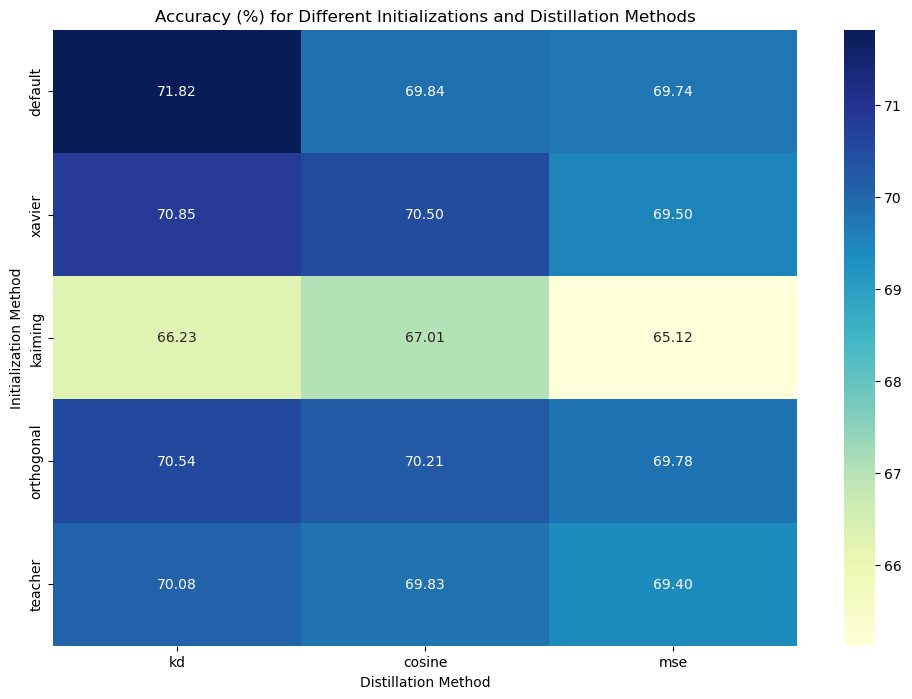

In [33]:
# Optionally, you can visualize the results using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(results).T
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Accuracy (%) for Different Initializations and Distillation Methods')
plt.ylabel('Initialization Method')
plt.xlabel('Distillation Method')
plt.show()